# 神经网络分类 SDSS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.metrics import categorical_crossentropy, categorical_accuracy
from keras.utils import np_utils
import seaborn as sns

import pydot_ng as pydot

## 读入数据

In [2]:
filename = 'Skyserver_12_30_2019 4_49_58 PM.csv'
sdss_df = pd.read_csv(filename, encoding='utf-8')
sdss_df = sdss_df.sample(frac=1)  # Pandas sample()用于从DataFrame中随机选择行和列
sdss_df.shape

(100000, 18)

## 删除不重要的列

In [3]:
sdss_df = sdss_df.drop(['objid', 'specobjid', 'run', 'rerun', 'camcol', 'field'], axis=1)

## 划分数据集

训练占60％，验证占20％，测试占20％

In [4]:
train_count = 60000
val_count = 20000
test_count = 20000

train_df = sdss_df.iloc[:train_count]   # 训练集
validation_df = sdss_df.iloc[train_count:train_count+val_count]  # 验证集
test_df = sdss_df.iloc[-test_count:]  # 测试集


## 删除标签

In [5]:
X_train = train_df.drop(['class'], axis=1)
X_validation = validation_df.drop(['class'], axis=1)
X_test = test_df.drop(['class'], axis=1)

## 对标签 进行硬编码 后
## 对标签 one-hot 编码

from sklearn.preprocessing import LabelEncoder 

keras.utils.to_categorical(y, num_classes=None, dtype='float32)

将整型的类别标签转为onehot编码。y为int数组，num_classes为标签类别总数，大于max(y)（标签从0开始的）

In [6]:
le = LabelEncoder()  # 使用LabelEncoder对特征进行硬编码  
le.fit(sdss_df['class'])   # 即将离散型的种类数据转换成 0 到 n−1 之间的数  通过fit函数传入需要编码的数据，在内部生成对应的key-value
encoded_Y = le.transform(sdss_df['class'])  # 用于需要转化的数据，用transform函数
onehot_labels = np_utils.to_categorical(encoded_Y)  # keras.utils.to_categorical 将类别标签转为onehot编码

y_train = onehot_labels[:train_count]
y_validation = onehot_labels[train_count:train_count+val_count]
y_test = onehot_labels[-test_count:]

In [7]:
encoded_Y

array([0, 0, 1, ..., 0, 1, 0])

In [8]:
onehot_labels

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       ...,
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.]], dtype=float32)

In [9]:
len(encoded_Y)

100000

In [10]:
onehot_labels.shape

(100000, 3)

In [11]:
y_test

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.]], dtype=float32)

## 数据缩放  标准化

from sklearn.preprocessing import StandardScaler  

StandardScaler类是一个用来讲数据进行归一化和标准化的类。标准化数据，保证每个维度的特征数据方差为1，均值为0，使得预测结果不会被某些维度过大的特征值而主导  

样本x的标准分数计算如下：z = (x - u) / s

标准化数据通过减去均值然后除以方差（或标准差），这种数据标准化方法经过处理后数据符合标准正态分布，即均值为0，标准差为1。

适用于：如果数据的分布本身就服从正态分布，就可以用这个方法。

In [12]:
scaler = StandardScaler()
scaler.fit(X_train) # fit scaler to training data only   fit()就是计算标准化所用到的均值与方差

X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)  # 利用fit（）的结果作为参数对数据进行相应的处理
X_validation = pd.DataFrame(scaler.transform(X_validation), columns=X_validation.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_validation.columns)

## 将PCA主成分分析应用于波长强度

In [13]:
pca = PCA(n_components=3)
dfs = [X_train, X_validation, X_test]

for i in range(len(dfs)):
    df = dfs[i]
    ugriz = pca.fit_transform(df[['u', 'g', 'r', 'i', 'z']])
    df = pd.concat((df, pd.DataFrame(ugriz)), axis=1)
    df.rename({0: 'PCA1', 1: 'PCA2', 2: 'PCA3'}, axis=1, inplace=True)
    df.drop(['u', 'g', 'r', 'i', 'z'], axis=1, inplace=True)
    dfs[i] = df
    
X_train, X_validation, X_test = dfs

In [14]:
X_train.head()

,ra,dec,redshift,plate,mjd,fiberid,PCA1,PCA2,PCA3
0,0.871309,-0.322317,-0.199325,0.171304,0.435518,-0.703581,-0.645468,-0.380347,-0.062678
1,0.430744,-0.169549,-0.288101,0.087616,0.396871,-1.439943,2.910053,0.968065,-0.239243
2,-0.199923,0.151372,2.651376,3.545838,2.716369,2.421355,-3.429198,0.620366,-0.021833
3,0.462253,0.704976,-0.173973,-0.544097,-0.533891,0.175451,-0.114218,-0.631304,0.107824
4,0.956304,0.232285,-0.393599,-0.561195,-0.721332,-0.832445,-1.630879,0.527283,0.297679


## 搭建深度神经网络模型

Keras--序贯模型（sequential）

单输入单输出，一条路通到底，层与层之间只有相邻关系，没有跨层连接。这种模型编译速度快，操作也比较简单

https://blog.csdn.net/zjw642337320/article/details/81204560

https://blog.csdn.net/rosefun96/article/details/110005568

keras.layers.Dense方法 Keras定义网络层的基本方法

https://blog.csdn.net/weixin_42499236/article/details/84624195

In [33]:
num_features = X_train.shape[1]
'''
    第一步：选择模型
'''
dnn = Sequential()  # 选择模型

'''
   第二步：构建网络层
'''
dnn.add(Dense(9, input_dim=num_features, activation='relu'))  #   input_dim输入层，9 ,输出层，9   # 激活函数是relu
dnn.add(Dropout(0.1))  # 采用10%的dropout

dnn.add(Dense(9, activation='relu'))  # 该隐藏层节点9个 
dnn.add(Dropout(0.1))

dnn.add(Dense(9, activation='relu'))   # 该隐藏层节点9个 
dnn.add(Dropout(0.05))

dnn.add(Dense(6, activation='relu'))   # 该隐藏层节点6个
dnn.add(Dropout(0.05))

dnn.add(Dense(6, activation='relu'))  # 该隐藏层节点6个

dnn.add(Dense(6, activation='relu'))   # 该隐藏层节点6个

dnn.add(Dense(3, activation='softmax', name='output'))   # 输出结果是3个类别，所以维度是3，最后一层用softmax作为激活函数

'''
   第三步：编译
'''
# optimizer优化函数，设定学习率（lr）等参数  
# categorical_accuracy：检查 y_ture 中最大值对应的index 与 y_pred 中最大值对应的index是否相等。
# 注意，这里只比较一个值，即最大的那个值的index，这对于【多分类单标签】任务的是合适的，但并不适用于【多标签】任务。
# 这里的 y_true 应为一个 one-hot 向量

dnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])  # 使用交叉熵作为loss函数


In [34]:
num_features

9

## 模型可视化

pip install pydot
pip install graphviz

from keras.utils import plot_model，执行plot_model需要graphviz的二进制文件

解决方法是在graphviz官网下载界面  http://www.graphviz.org/download/  选择自己操作系统对应的版本的.msi文件

安装时选择添加环境变量


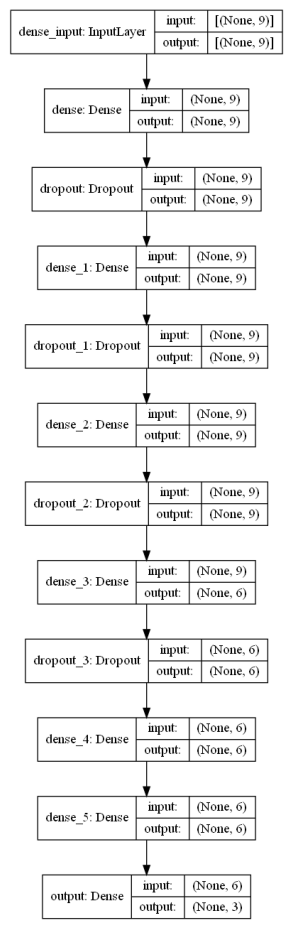

In [31]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.utils import plot_model
#from tensorflow.python.keras.utils import plot_model

plot_model(dnn, to_file='model.png', show_shapes=True, show_layer_names=True)
img = mpimg.imread('model.png')
plt.figure(figsize=(5, 30))
plt.imshow(img)
plt.axis('off')
plt.show()


In [32]:
dnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 9)                 90        
_________________________________________________________________
dropout (Dropout)            (None, 9)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 90        
_________________________________________________________________
dropout_1 (Dropout)          (None, 9)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 90        
_________________________________________________________________
dropout_2 (Dropout)          (None, 9)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 6

# 训练

In [35]:
'''
   第四步：训练
   .fit的一些参数
   batch_size：对总的样本数进行分组，每组包含的样本数量
   epochs ：训练次数
   shuffle：是否把数据随机打乱之后再进行训练
   validation_split：拿出百分之多少用来做交叉验证
   verbose：屏显模式 0：不输出  1：输出进度  2：输出每次的训练结果
   validation_data：在训练的每个epoch后验证模型，防止过度拟合  # X_validation 验证集
'''

my_epochs = 50
history = dnn.fit(X_train, y_train, epochs=my_epochs, batch_size=50,validation_data=(X_validation, y_validation))

Epoch 1/50
1200/1200 [==============================] - 1s 709us/step - loss: 0.8599 - categorical_accuracy: 0.6829 - val_loss: 0.3666 - val_categorical_accuracy: 0.9086
Epoch 2/50
1200/1200 [==============================] - 1s 576us/step - loss: 0.3562 - categorical_accuracy: 0.8983 - val_loss: 0.1824 - val_categorical_accuracy: 0.9633
Epoch 3/50
1200/1200 [==============================] - 1s 572us/step - loss: 0.2134 - categorical_accuracy: 0.9488 - val_loss: 0.1368 - val_categorical_accuracy: 0.9697
Epoch 4/50
1200/1200 [==============================] - 1s 574us/step - loss: 0.1589 - categorical_accuracy: 0.9615 - val_loss: 0.0958 - val_categorical_accuracy: 0.9765
Epoch 5/50
1200/1200 [==============================] - 1s 569us/step - loss: 0.1241 - categorical_accuracy: 0.9708 - val_loss: 0.0859 - val_categorical_accuracy: 0.9793
Epoch 6/50
1200/1200 [==============================] - 1s 569us/step - loss: 0.1086 - categorical_accuracy: 0.9722 - val_loss: 0.0757 - val_categoric

Epoch 49/50
1200/1200 [==============================] - 1s 576us/step - loss: 0.0670 - categorical_accuracy: 0.9827 - val_loss: 0.0571 - val_categorical_accuracy: 0.9866
Epoch 50/50
1200/1200 [==============================] - 1s 569us/step - loss: 0.0719 - categorical_accuracy: 0.9815 - val_loss: 0.0553 - val_categorical_accuracy: 0.9868


# 评估模型

## 绘制训练过程中的损失

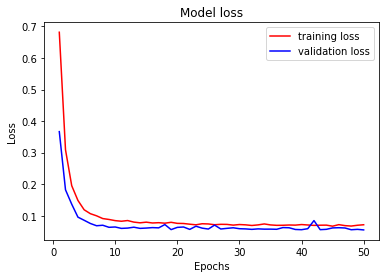

In [36]:
epochs_arr = np.arange(1, my_epochs + 1, 1)
my_history = history.history
line1 = plt.plot(epochs_arr, my_history['loss'], 'r-', label='training loss')
line2 = plt.plot(epochs_arr, my_history['val_loss'], 'b-', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model loss')
plt.legend()
plt.show()

## 绘制训练时模型的准确性

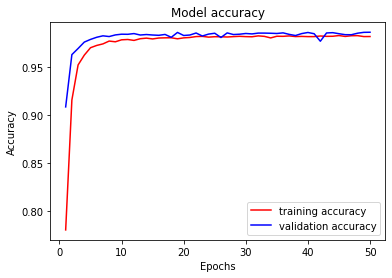

In [37]:
line1 = plt.plot(epochs_arr, my_history['categorical_accuracy'], 'r-', label='training accuracy')
line2 = plt.plot(epochs_arr, my_history['val_categorical_accuracy'], 'b-', label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model accuracy')
plt.legend()
plt.show()

In [38]:
preds = pd.DataFrame(dnn.predict(X_validation))
preds = preds.idxmax(axis=1)
y_validation = y_validation.dot([0,1,2])
model_acc = (preds == y_validation).sum().astype(float) / len(preds) * 100

print('Deep Neural Network')
print('Validation Accuracy: %3.5f' % (model_acc))

Deep Neural Network
Validation Accuracy: 98.67500


# 对测试集进行预测

In [39]:
preds = pd.DataFrame(dnn.predict(X_test))
preds = preds.idxmax(axis=1)
y_test = y_test.dot([0,1,2])
model_acc = (preds == y_test).sum().astype(float) / len(preds) * 100

print('Deep Neural Network')
print('Test Accuracy: %3.5f' % (model_acc))

Deep Neural Network
Test Accuracy: 98.56500


## 混淆矩阵

纵轴为真实分类，横轴为网络分类

sklearn.metrics.confusion_matrix(y_true, y_pred, labels=None, sample_weight=None)

y_true: 是样本真实分类结果，y_pred: 是样本预测分类结果
labels：是所给出的类别，通过这个可对类别进行选择
sample_weight : 样本权重

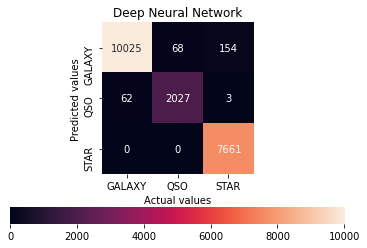

In [43]:
labels = np.unique(sdss_df['class'])
ax = plt.subplot(1, 1, 1)
ax.set_aspect(1)
plt.subplots_adjust(wspace = 0.3)
sns.heatmap(confusion_matrix(y_test, preds), annot=True,fmt='d', xticklabels = labels, yticklabels = labels,
                  cbar_kws={'orientation': 'horizontal'})
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Deep Neural Network')
plt.show()

## 精确率和召回率

In [45]:
cm = confusion_matrix(y_test, preds)
precision = np.diag(cm) / np.sum(cm, axis = 0)
recall = np.diag(cm) / np.sum(cm, axis = 1)

print('Recall: ', precision)
print('Precision: ', recall)

Recall:  [0.99385347 0.96754177 0.97991814]
Precision:  [0.97833512 0.96892925 1.        ]


In [46]:
cm

array([[10025,    68,   154],
       [   62,  2027,     3],
       [    0,     0,  7661]], dtype=int64)

星系的精度为97.8％，召回率为99.3％。

类星体的精度为96.8％，召回率为96.7％。

恒星的精度为100％，召回率为97.9％。

换句话说，我的模型在星系和恒星上的性能要比类星体好得多。这是有道理的，因为类星体在我的100,000个样本中是少数。